# Movie Preference Vectors Using Matrix Factorization


Use graphlab package to do matrix factorization on Movielens-20m movie rating data. The purpose is to get preference vectors for movies.

In [2]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt

ratings = pd.read_csv("data/ml-20m/ratings.csv")

## Exclude rarely rated movies and highly active users

To reduce noise and also to bring down the size of the data set, we exclude moveis rated only by a handful of people and users who have rated too many movies.

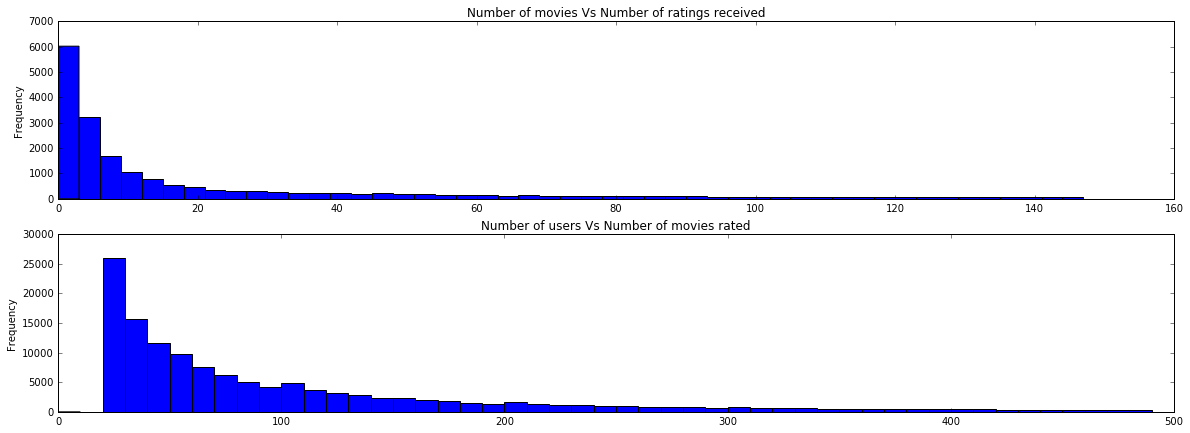

In [3]:
fig, axes = plt.subplots(2, figsize=(20, 7))

movie_counts = ratings.groupby("movieId").count().userId
user_counts = ratings.groupby("userId").count().movieId
movie_counts.plot(kind='hist', bins=range(0, 150, 3), ax=axes[0]).set_title("Number of movies Vs Number of ratings received")
user_counts.plot(kind='hist', bins=range(0, 500, 10), ax=axes[1]).set_title("Number of users Vs Number of movies rated")
user_counts = dict(user_counts)
movie_counts = dict(movie_counts)

In [4]:
%%time

ratings['mcounts'] = ratings.apply(lambda x: movie_counts[x.movieId], axis=1)
ratings['ucounts'] = ratings.apply(lambda x: user_counts[x.userId], axis=1)

# Ideally the comparisons should be done sequentially as one affects the other. Doing this as an approximation.
ratings_small = ratings[(ratings.mcounts > 100) # Movies that at least 100 people rated
                          & (ratings.ucounts < 150)] # Users who rated less than 150 movies 

Wall time: 8min 3s


In [8]:
import graphlab as gl
ratings_sf = gl.SFrame(ratings_small)
(train_set, test_set) = ratings_sf.random_split(0.7)

[INFO] 1450331595 : INFO:     (initialize_globals_from_environment:282): Setting configuration variable GRAPHLAB_FILEIO_ALTERNATIVE_SSL_CERT_FILE to E:\Anaconda\envs\dato-env\lib\site-packages\certifi\cacert.pem
1450331595 : INFO:     (initialize_globals_from_environment:282): Setting configuration variable GRAPHLAB_FILEIO_ALTERNATIVE_SSL_CERT_DIR to 
This non-commercial license of GraphLab Create is assigned to soorajraveendran@g.harvard.edu and will expire on December 13, 2016. For commercial licensing options, visit https://dato.com/buy/.

[INFO] Start server at: ipc:///tmp/graphlab_server-4428 - Server binary: E:\Anaconda\envs\dato-env\lib\site-packages\graphlab\unity_server.exe - Server log: C:\Users\SOORAJ~1.RAV\AppData\Local\Temp\graphlab_server_1450331596.log.0
[INFO] GraphLab Server Version: 1.7.1


In [9]:
%%time

import itertools

regularization_vals = [0.00001, 0.000001]
vector_lengths = [50, 80]

models = [gl.factorization_recommender.create(train_set, 'userId', 'movieId', 'rating',
                                              max_iterations=100, num_factors=factors, 
                                              regularization=reg, solver='sgd')
          for reg, factors in itertools.product(regularization_vals, vector_lengths)]

PROGRESS: Recsys training: model = factorization_recommender
PROGRESS: Preparing data set.
PROGRESS:     Data has 4168960 observations with 102676 users and 8527 items.
PROGRESS:     Data prepared in: 4.12981s
PROGRESS: Training factorization_recommender for recommendations.
PROGRESS: +--------------------------------+--------------------------------------------------+----------+
PROGRESS: | Parameter                      | Description                                      | Value    |
PROGRESS: +--------------------------------+--------------------------------------------------+----------+
PROGRESS: | num_factors                    | Factor Dimension                                 | 50       |
PROGRESS: | regularization                 | L2 Regularization on Factors                     | 1e-005   |
PROGRESS: | solver                         | Solver used for training                         | sgd      |
PROGRESS: | linear_regularization          | L2 Regularization on Linear Coefficie

In [10]:
%%time

# Find the best model
best_model = None
smallest_error = 10.0
for m in models:
    rmse = gl.evaluation.rmse(test_set['rating'], m.predict(test_set))
    if(rmse < smallest_error):
        smallest_error = rmse
        best_model = m

print("The best model: Training RMSE %f, test RMSE %f" % (best_model['training_rmse'], smallest_error))

The best model: Training RMSE 0.938036, test RMSE 0.944222
Wall time: 3.33 s


In [11]:
best_model

Class                           : FactorizationRecommender

Schema
------
User ID                         : userId
Item ID                         : movieId
Target                          : rating
Additional observation features : 3
Number of user side features    : 0
Number of item side features    : 0

Statistics
----------
Number of observations          : 4168960
Number of users                 : 102676
Number of items                 : 8527

Training summary
----------------
Training time                   : 93.6448

Model Parameters
----------------
Model class                     : FactorizationRecommender
num_factors                     : 50
binary_target                   : 0
side_data_factorization         : 1
solver                          : sgd
nmf                             : 0
max_iterations                  : 100

Regularization Settings
-----------------------
regularization                  : 0.0
regularization_type             : normal
linear_regularization        

## Save the vectors

In [16]:
prefvectors = best_model.coefficients['movieId']['movieId', 'factors'].to_dataframe()
prefvectors.to_csv("prefvectors.csv")

## Project the vectors to 2D and visualize

In [21]:
from sklearn.manifold import TSNE, MDS, Isomap
from sklearn.decomposition import PCA

def apply_mds(vectors):
    mds = MDS(n_components=2, random_state=1).fit_transform(vectors)
    df = pd.DataFrame(columns=['x', 'y'])
    df['x'] = mds[:, 0]
    df['y'] = mds[:, 1]
    return df

def apply_tsne(vectors, rate=1000):
    tsne = TSNE(learning_rate=rate, init='pca', perplexity=10, early_exaggeration=20.0, random_state=1).fit_transform(vectors)
    df = pd.DataFrame(columns=['x', 'y'])
    df['x'] = tsne[:, 0]
    df['y'] = tsne[:, 1]
    return df

def apply_pca(vectors):
    pca = PCA().fit_transform(vectors)
    df = pd.DataFrame(columns=['x', 'y'])
    df['x'] = pca[:, 0]
    df['y'] = pca[:, 1]
    return df

def apply_isomap(vectors, neighbours=10):
    map_2d = Isomap(neighbours, 2, eigen_solver='auto').fit_transform(vectors)    
    df = pd.DataFrame(map_2d, columns=['x', 'y'])
    return df


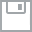
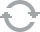
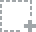
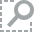
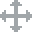
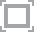
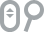
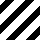
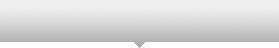
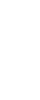
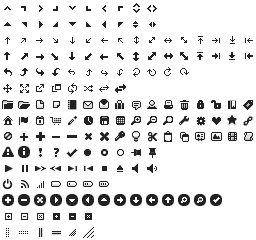
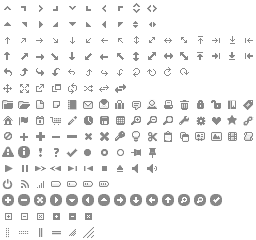
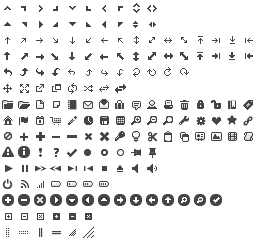
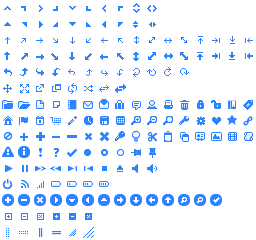
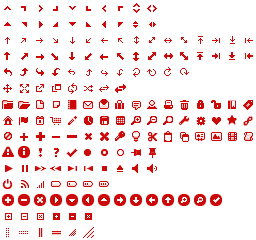
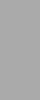
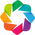
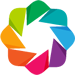

In [52]:
'''
Plotting code taken from https://github.com/soorajmr/moviemeta/blob/master/notebooks/doc2vec.ipynb
'''    

import bokeh.plotting as bp
from bokeh.models import HoverTool, BoxSelectTool
from bokeh.plotting import figure, show, output_notebook
import seaborn as sns
output_notebook()

'''
Scatter plot using bokeh library
Adapted from: http://aylien.com/web-summit-2015-tweets-part1

@param df - DataFrame with columns x and y
@param labels - list of labels for each point
@param categories - list of categories for each point (category assignments)
@param title - title for the plot
@param categories_to_show - list of categories to use for colour-coding. 
                            All other categories will be labelled "Other"
@param point_label - common prefix string for the tooltip label for all points
@param static_label - whether to annotate the points statically (not on mouseover)

'''
def plot_2d_scatter_bokeh(df, labels, categories, title, categories_to_show = None, point_label="movie", static_label=False):
    bplot = bp.figure(plot_width=800, plot_height=800, title=title,
        tools="pan,wheel_zoom,box_zoom,reset,hover,previewsave",
        x_axis_type=None, y_axis_type=None, min_border=2, background_fill="#EAEAF5")

    color_assignment = []

    if(categories is not None):
        if(categories_to_show is None):
            categories_to_show = list(set(categories))

        #pal = sns.color_palette('cubehelix', len(categories_to_show))
        color_list = sns.xkcd_palette(['purple', 'green', 'blue', 'pink', 'brown', 'red', 'orange', 'yellow', 
                                       'rose', 'pea green', 'mustard', 'fuchsia', 'beige', 
                                       'cloudy blue', 'candy pink', 'golden rod', 'salmon', 'light brown', 
                                       'aquamarine', 'mauve', 'lilac']).as_hex()[:len(categories_to_show)]

        for i in range(0, len(categories)):
            try:
                cat_index = categories_to_show.index(categories[i])
            except:
                # Assuming the default category named "Other"
                cat_index = categories_to_show.index("Other")

            color_assignment.append((color_list[cat_index]))
    else:
        categories = labels
        color_assignment = ["#221122"] * len(labels)
        
    bplot.scatter(x = df.x, y = df.y, alpha=0.5,
                        color = color_assignment,
                        source = bp.ColumnDataSource({"label": labels,
                                                      "category": categories}))
    if(static_label):
        bplot.text(x = df.x, y = df.y,
                    text=labels, text_color="#662222",
                    text_align="right", text_font_size="8pt")
    
    hover = bplot.select(dict(type = HoverTool))
    if(static_label):
        hover.tooltips = {"%s" % point_label: "@label"}
    else:
        hover.tooltips = {"%s" % point_label: "@label - @category"}
    
    show(bplot)
    return bplot


In [40]:
movies = pd.read_csv("data/ml-20m/movies.csv")
titlemap = dict(zip(movies.movieId, movies.title))
titles = list(prefvectors.apply(lambda x: titlemap[x.movieId], axis=1))

In [53]:
pref2d = apply_pca(map(list, prefvectors.factors))
plot_2d_scatter_bokeh(pref2d, titles, None, "Movie Preference Vectors", static_label=True)